# Financial Agent Evaluation Demonstration

This notebook demonstrates how to evaluate a financial advisory agent using the framework developed for the Day 5 workshop. We'll analyze the agent's responses to financial queries and assess its performance on key metrics.

In [1]:
import sys
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Any, Optional, Union

# Import the financial agent implementation
sys.path.append('.')
# This will import your FinancialAdvisorAgent class from the notebook
from financial_agent_starter import financial_tools, simulate_tool_execution, FinancialAdvisorAgent
from updated_api_utils import call_openrouter_with_tools, extract_tool_call, extract_text_response_with_tools
from api_utils import extract_text_response

Step 1 - Message received:
{'role': 'assistant', 'content': '', 'refusal': None, 'reasoning': None, 'tool_calls': [{'index': 0, 'id': 'call_dmvEtlwfJ6raUZiCRjPEWXox', 'type': 'function', 'function': {'name': 'get_stock_price', 'arguments': '{"ticker":"AAPL"}'}}]}
Step 1: Used tool 'get_stock_price' with result: {'success': True, 'price': 198.73, 'currency': 'USD', 'timestamp': '2024-05-19T16:00:00Z'}
Conversation history length: 4
Step 2 - Message received:
{'role': 'assistant', 'content': "1. **THOUGHT**: The current price of Apple stock (AAPL) is needed to provide the user with the latest market information.\n\n2. **ACTION**: I retrieved the current stock price for Apple (AAPL).\n\n3. **OBSERVATION**: The current price of Apple stock is $198.73 USD.\n\n4. **THOUGHT**: With this information, I can inform the user about the current market value of Apple stock.\n\n5. **RECOMMENDATION**: The current price of Apple stock (AAPL) is $198.73. If you are considering investing in Apple, this p

## 1. Automated Evaluation Framework

To make evaluation more consistent and easier to interpret, we'll create an automated evaluation framework that scores agent responses based on pre-defined criteria.

In [2]:
# Define the evaluation criteria
evaluation_criteria = [
    "Factual Accuracy",     # Was the financial information correct?
    "Tool Usage",           # Did the agent use appropriate tools?
    "Reasoning Quality",    # Was the financial reasoning sound?
    "Comprehensiveness",    # Did the answer cover all aspects of the query?
    "Clarity",              # Was the advice clearly presented?
    "Risk Disclosure"       # Did the agent mention relevant risks?
]

# This function will be implemented to automatically score responses
# In a real-world scenario, this would be done either by human evaluators or by a specialized evaluation model
def auto_evaluate_response(query, response, agent_history):
    """Simulated automatic evaluation of agent responses.
    
    In a real implementation, this would be much more sophisticated. For demonstration,
    we'll use simple heuristics based on response length, tool usage, and keyword presence.
    """
    # Extract tool usage from agent history
    tool_calls = [msg for msg in agent_history if msg.get("role") == "tool"]
    
    # Simple heuristic scoring (this would be much more sophisticated in practice)
    scores = {}
    
    # Factual Accuracy - based on tool usage
    scores["Factual Accuracy"] = min(5, len(tool_calls) + 2)
    
    # Tool Usage - more tools used (up to a point) suggests better tool usage
    scores["Tool Usage"] = min(5, len(tool_calls) + 1)
    
    # Reasoning Quality - look for reasoning keywords
    reasoning_keywords = ["because", "therefore", "as a result", "given that", "considering"]
    reasoning_count = sum(1 for keyword in reasoning_keywords if keyword.lower() in response.lower())
    scores["Reasoning Quality"] = min(5, reasoning_count + 2)
    
    # Comprehensiveness - based on response length and tool diversity
    response_length = len(response.split())
    unique_tools = len(set(msg.get("name") for msg in tool_calls if "name" in msg))
    scores["Comprehensiveness"] = min(5, 2 + (response_length > 100) + unique_tools)
    
    # Clarity - simple heuristic based on sentence length
    sentences = response.split(".")
    avg_sentence_length = sum(len(s.split()) for s in sentences) / max(1, len(sentences))
    scores["Clarity"] = 5 if 8 <= avg_sentence_length <= 20 else max(2, 6 - abs(avg_sentence_length - 14) / 4)
    
    # Risk Disclosure - check for risk-related keywords
    risk_keywords = ["risk", "volatility", "uncertain", "potential loss", "limitation", "no guarantee"]
    risk_count = sum(1 for keyword in risk_keywords if keyword.lower() in response.lower())
    scores["Risk Disclosure"] = min(5, risk_count + 1)
    
    # Round all scores
    scores = {k: round(v) for k, v in scores.items()}
    
    return scores

def evaluate_agent(agent, test_queries, auto_eval=True):
    """Evaluate the financial agent against a set of test queries."""
    results = []
    
    for i, query in enumerate(test_queries):
        print(f"\nEvaluating query {i+1}/{len(test_queries)}: {query}")
        
        # Reset the agent's conversation history and execute the query
        agent.conversation_history = []
        response = agent.execute_react_loop(query)
        
        # Get the complete conversation history for analysis
        history = agent.conversation_history.copy()
        
        # Score the response
        if auto_eval:
            scores = auto_evaluate_response(query, response, history)
            average_score = sum(scores.values()) / len(scores)
            
            print(f"\nAutomatic Evaluation Results:")
            for criterion, score in scores.items():
                print(f"{criterion}: {score}/5")
            print(f"Average Score: {average_score:.2f}/5.00")
        else:
            # Manual evaluation (in a workshop setting)
            print("\nPlease rate the response on the following criteria (1-5):")
            scores = {}
            for criterion in evaluation_criteria:
                try:
                    score = int(input(f"{criterion} (1-5): "))
                    scores[criterion] = min(max(score, 1), 5)  # Ensure score is between 1-5
                except ValueError:
                    scores[criterion] = 3  # Default to middle score if invalid input
            average_score = sum(scores.values()) / len(scores)
        
        # Save the results
        results.append({
            "query_id": i+1,
            "query": query,
            "response": response,
            "history": history,
            "scores": scores,
            "average_score": average_score
        })
    
    # Calculate overall scores
    overall_average = sum(result["average_score"] for result in results) / len(results)
    criterion_averages = {}
    for criterion in evaluation_criteria:
        criterion_averages[criterion] = sum(result["scores"][criterion] for result in results) / len(results)
    
    print(f"\nOverall Evaluation Results:")
    print(f"Overall Average Score: {overall_average:.2f}/5.00")
    print("\nAverage Scores by Criterion:")
    for criterion, avg in criterion_averages.items():
        print(f"{criterion}: {avg:.2f}/5.00")
    
    return results, criterion_averages, overall_average

## 2. Define Test Queries

We'll use a subset of the financial queries from Day 2 to evaluate the agent.

In [4]:
# Short list of test queries for demonstration
test_queries = [
    "What is the current price of Apple stock?",
    "Calculate the compound interest on a $10,000 investment at 5% annually over 10 years.",
    "Compare the P/E ratios of Microsoft and Amazon.",
    "What is the current federal funds rate and how does it affect the stock market?",
    "How do I build a diversified investment portfolio?"
]

# You can add more queries from the financial_queries.txt file in Day 2

## 3. Create and Test the Baseline Agent

First, let's evaluate the baseline financial agent without any enhancements.

In [5]:
# Create the baseline financial agent
# For this demonstration, we'll use a smaller model to speed up responses
baseline_agent = FinancialAdvisorAgent(model="openai/gpt-4o-mini-2024-07-18")

# Evaluate the baseline agent
baseline_results, baseline_criterion_averages, baseline_overall = evaluate_agent(baseline_agent, test_queries[:2])


Evaluating query 1/2: What is the current price of Apple stock?
Step 1 - Message received:
{'role': 'assistant', 'content': '', 'refusal': None, 'reasoning': None, 'tool_calls': [{'index': 0, 'id': 'call_gmNF5pHsbUebDTS36yTEGgIY', 'type': 'function', 'function': {'name': 'get_stock_price', 'arguments': '{"ticker":"AAPL"}'}}]}
Step 1: Used tool 'get_stock_price' with result: {'success': True, 'price': 198.73, 'currency': 'USD', 'timestamp': '2024-05-19T16:00:00Z'}
Conversation history length: 4
Step 2 - Message received:
{'role': 'assistant', 'content': "1. **THOUGHT**: The current price of Apple stock (AAPL) is needed.\n\n2. **ACTION**: I retrieved the current stock price for Apple.\n\n3. **OBSERVATION**: The current price of Apple stock is $198.73 USD as of May 19, 2024.\n\n4. **THOUGHT**: With this information, I can provide insights or further analysis if needed.\n\n5. **RECOMMENDATION**: If you're considering investing in Apple stock, it's essential to analyze its performance over

## 4. Demonstration: Enhanced Agent with Reflection

Now let's implement the reflection mechanism from the exercises and evaluate the enhanced agent.

In [6]:
class EnhancedFinancialAgent(FinancialAdvisorAgent):
    """
    Enhanced financial advisor agent with reflection capabilities.
    This implements Exercise 1 from the workshop exercises.
    """
    
    def reflect_on_response(self, response, query):
        """Reflect on the quality of the financial advice provided."""
        # Create a prompt for the reflection model
        reflection_prompt = f"""
        As a financial advisor quality control specialist, evaluate the following financial advice.
        
        QUERY: {query}
        
        RESPONSE: {response}
        
        Please analyze the response on the following criteria:
        1. Factual Accuracy: Is the financial information correct and precisely stated?
        2. Evidence-Based Reasoning: Is the advice supported by data and sound financial principles?
        3. Completeness: Are there important financial considerations that were missed?
        4. Risk Disclosure: Are the risks adequately explained?
        5. Clarity: Is the advice clearly presented and easy to understand?
        
        For each criterion, assign a score from 1-5, where 5 is excellent.
        Then provide specific recommendations for improving the response.
        """
        
        # Call the model for reflection
        reflection_response = call_openrouter_with_tools(
            prompt=reflection_prompt,
            model=self.model,
            temperature=0.2,
            max_tokens=1000
        )
        
        # Extract the reflection
        reflection = extract_text_response_with_tools(reflection_response)
        
        return reflection
    
    def execute_react_loop_with_reflection(self, query, max_steps=5):
        """Execute the ReAct loop and then reflect on the response."""
        # Get the initial response
        response = self.execute_react_loop(query, max_steps)
        
        # Reflect on the response
        reflection = self.reflect_on_response(response, query)
        
        # Log the reflection (in a real agent, this could be used to improve the response)
        print(f"\nAGENT REFLECTION:\n{reflection}")
        
        return response

In [7]:
# Create and test the enhanced agent
enhanced_agent = EnhancedFinancialAgent(model="openai/gpt-4o-mini-2024-07-18")

# Test the enhanced agent on a single query first
query = "What is the current price of Apple stock?"
response = enhanced_agent.execute_react_loop_with_reflection(query)

Step 1 - Message received:
{'role': 'assistant', 'content': '', 'refusal': None, 'reasoning': None, 'tool_calls': [{'index': 0, 'id': 'call_RACXA7THyHkiL8RdoDoJJxKW', 'type': 'function', 'function': {'name': 'get_stock_price', 'arguments': '{"ticker":"AAPL"}'}}]}
Step 1: Used tool 'get_stock_price' with result: {'success': True, 'price': 198.73, 'currency': 'USD', 'timestamp': '2024-05-19T16:00:00Z'}
Conversation history length: 4
Step 2 - Message received:
{'role': 'assistant', 'content': 'The current price of Apple stock (AAPL) is $198.73 USD. \n\nIf you have any further questions or need additional information regarding Apple or other investments, feel free to ask!', 'refusal': None, 'reasoning': None}

Final Response:
The current price of Apple stock (AAPL) is $198.73 USD. 

If you have any further questions or need additional information regarding Apple or other investments, feel free to ask!

AGENT REFLECTION:
### Evaluation of the Response

1. **Factual Accuracy: 2/5**
   - The 

## 5. Comparing Agent Performance

Now let's compare the performance of the baseline and enhanced agents.

In [8]:
# For a real comparison, we would evaluate the enhanced agent on all test queries
# For brevity in this demonstration, we'll only use a subset
enhanced_results, enhanced_criterion_averages, enhanced_overall = evaluate_agent(
    enhanced_agent, test_queries[:2])

# Create a comparison DataFrame
comparison_data = {
    "Baseline": baseline_criterion_averages,
    "Enhanced": enhanced_criterion_averages
}
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison
print("\nAgent Performance Comparison:")
print(comparison_df)
print(f"\nOverall Scores:\nBaseline: {baseline_overall:.2f}/5.00\nEnhanced: {enhanced_overall:.2f}/5.00")


Evaluating query 1/2: What is the current price of Apple stock?
Step 1 - Message received:
{'role': 'assistant', 'content': '', 'refusal': None, 'reasoning': None, 'tool_calls': [{'index': 0, 'id': 'call_YsFifymjhhnOJq0vu8o9d0B4', 'type': 'function', 'function': {'name': 'get_stock_price', 'arguments': '{"ticker":"AAPL"}'}}]}
Step 1: Used tool 'get_stock_price' with result: {'success': True, 'price': 198.73, 'currency': 'USD', 'timestamp': '2024-05-19T16:00:00Z'}
Conversation history length: 4
Step 2 - Message received:
{'role': 'assistant', 'content': 'The current price of Apple stock (AAPL) is $198.73 USD. \n\nIf you have any further questions or need additional information, feel free to ask!', 'refusal': None, 'reasoning': None}

Final Response:
The current price of Apple stock (AAPL) is $198.73 USD. 

If you have any further questions or need additional information, feel free to ask!

Automatic Evaluation Results:
Factual Accuracy: 3/5
Tool Usage: 2/5
Reasoning Quality: 2/5
Compre

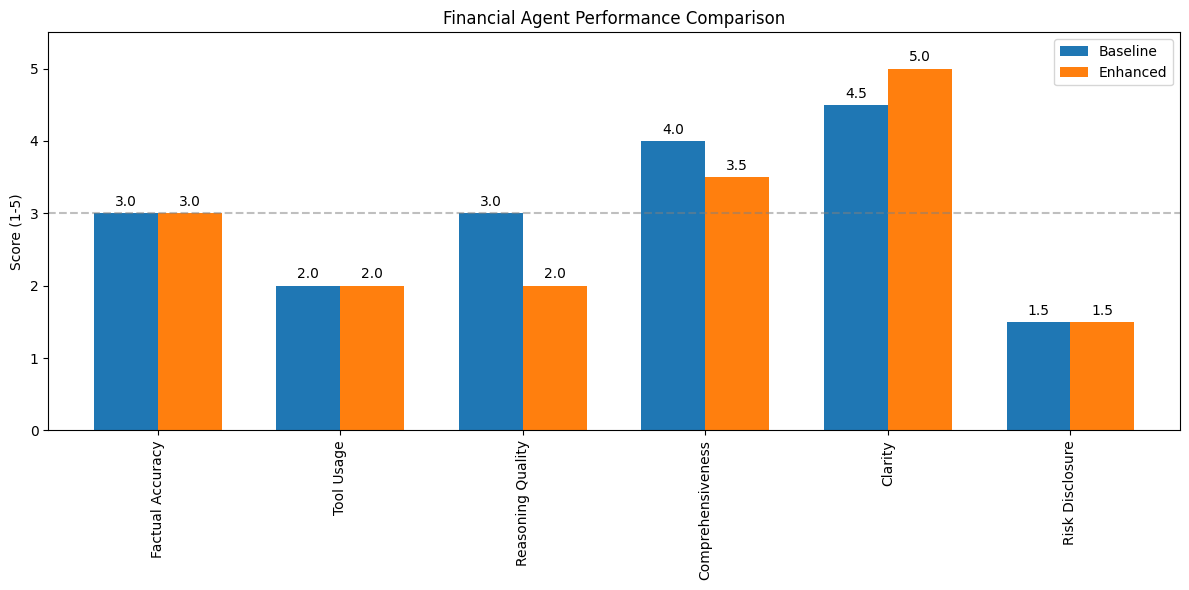

In [9]:
# Visualize the comparison
ax = comparison_df.plot(kind='bar', figsize=(12, 6), width=0.7)
ax.set_ylim(0, 5.5)
ax.set_ylabel('Score (1-5)')
ax.set_title('Financial Agent Performance Comparison')
ax.axhline(y=3, color='gray', linestyle='--', alpha=0.5)  # Add a line at the midpoint score

# Add value labels above each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

plt.tight_layout()
plt.show()

## 6. Agent Response Analysis

Let's analyze the agent's responses in more detail to understand its strengths and weaknesses.

In [10]:
def analyze_tools_used(agent_results):
    """Analyze the tools used by the agent across all queries."""
    tool_usage = {}
    
    for result in agent_results:
        history = result["history"]
        query = result["query"]
        
        # Extract tool calls
        tools_used = []
        for msg in history:
            if msg.get("role") == "tool" and "name" in msg:
                tools_used.append(msg["name"])
        
        tool_usage[query] = tools_used
    
    return tool_usage

# Analyze tool usage for the enhanced agent
tool_analysis = analyze_tools_used(enhanced_results)

print("Tool Usage Analysis:")
for query, tools in tool_analysis.items():
    print(f"\nQuery: {query}")
    if tools:
        print(f"Tools used: {', '.join(tools)}")
    else:
        print("No tools used")

Tool Usage Analysis:

Query: What is the current price of Apple stock?
Tools used: get_stock_price

Query: Calculate the compound interest on a $10,000 investment at 5% annually over 10 years.
Tools used: calculate_investment_return


## 7. Workshop Exercise: Portfolio Diversification Tool

Now let's implement Exercise 2 from the workshop exercises: adding a portfolio diversification tool.

In [11]:
# Define the portfolio diversification tool
portfolio_diversification_tool = {
    "name": "get_portfolio_recommendation",
    "description": "Get portfolio allocation recommendations based on risk tolerance and time horizon",
    "parameters": {
        "type": "object",
        "properties": {
            "risk_tolerance": {
                "type": "string",
                "description": "Investor's risk tolerance",
                "enum": ["conservative", "moderate", "aggressive"]
            },
            "time_horizon": {
                "type": "string",
                "description": "Investment time horizon",
                "enum": ["short_term", "medium_term", "long_term"]
            }
        },
        "required": ["risk_tolerance", "time_horizon"]
    }
}

# Add the tool implementation to our simulator
def simulate_portfolio_recommendation(arguments):
    """Simulate a portfolio recommendation based on risk tolerance and time horizon."""
    risk_tolerance = arguments.get("risk_tolerance", "moderate")
    time_horizon = arguments.get("time_horizon", "medium_term")
    
    # Portfolio allocation recommendations based on risk and horizon
    portfolios = {
        "conservative": {
            "short_term": {"cash": 30, "bonds": 60, "stocks": 10, "alternatives": 0},
            "medium_term": {"cash": 20, "bonds": 55, "stocks": 20, "alternatives": 5},
            "long_term": {"cash": 10, "bonds": 50, "stocks": 30, "alternatives": 10}
        },
        "moderate": {
            "short_term": {"cash": 25, "bonds": 45, "stocks": 25, "alternatives": 5},
            "medium_term": {"cash": 15, "bonds": 35, "stocks": 40, "alternatives": 10},
            "long_term": {"cash": 5, "bonds": 25, "stocks": 55, "alternatives": 15}
        },
        "aggressive": {
            "short_term": {"cash": 20, "bonds": 20, "stocks": 50, "alternatives": 10},
            "medium_term": {"cash": 10, "bonds": 15, "stocks": 60, "alternatives": 15},
            "long_term": {"cash": 5, "bonds": 10, "stocks": 70, "alternatives": 15}
        }
    }
    
    # Get the recommended allocation
    if risk_tolerance in portfolios and time_horizon in portfolios[risk_tolerance]:
        allocation = portfolios[risk_tolerance][time_horizon]
        return {
            "success": True,
            "risk_tolerance": risk_tolerance,
            "time_horizon": time_horizon,
            "allocation": allocation,
            "explanation": f"This {risk_tolerance} portfolio for {time_horizon.replace('_', ' ')} investors balances risk and return by allocating {allocation['stocks']}% to stocks, {allocation['bonds']}% to bonds, {allocation['cash']}% to cash, and {allocation['alternatives']}% to alternative investments."
        }
    else:
        return {"success": False, "error": "Invalid risk tolerance or time horizon"}

# Update the simulate_tool_execution function to handle the new tool
original_simulate_tool_execution = simulate_tool_execution

def enhanced_simulate_tool_execution(function_name, arguments):
    """Enhanced simulation that includes the portfolio diversification tool."""
    if function_name == "get_portfolio_recommendation":
        return simulate_portfolio_recommendation(arguments)
    else:
        return original_simulate_tool_execution(function_name, arguments)

# Create an agent with the enhanced toolset
class EnhancedPortfolioAgent(EnhancedFinancialAgent):
    def __init__(self, model="openai/gpt-4o-mini-2024-07-18"):
        super().__init__(model=model)
        # Add the portfolio tool to the existing tools
        self.tools = financial_tools + [portfolio_diversification_tool]
        
    def execute_react_loop(self, query, max_steps=5):
        """Override to use the enhanced tool execution."""
        # Reset conversation and add system prompt
        self.conversation_history = []
        
        # Add system prompt with ReAct instructions
        system_prompt = """
        You are a financial advisor agent that helps people with investment questions and financial planning. 
        Use the ReAct framework to solve financial queries by following these steps:
        
        1. THOUGHT: Analyze the query and determine what financial information is needed to answer it.
        2. ACTION: Use the appropriate financial tool to retrieve relevant data.
        3. OBSERVATION: Review the tool's response and extract key insights.
        4. THOUGHT: Analyze the information and determine next steps or final recommendation.
        5. Repeat steps 2-4 as needed until you have all necessary information.
        6. When ready, provide your final RECOMMENDATION with well-reasoned financial advice.
        
        After your recommendation, include a REFLECTION on your reasoning process and the confidence in your advice.
        
        IMPORTANT: Always cite your sources and explain your financial reasoning. Be transparent about the limitations 
        of your advice. Use tools to get real data rather than making assumptions.
        """
        
        self.add_system_message(system_prompt)
        self.add_user_message(query)
        
        # Execute the ReAct loop
        for step in range(max_steps):
            # Get the next action from the model
            response = call_openrouter_with_tools(
                prompt=self.conversation_history,
                model=self.model,
                tools=self.tools,
                temperature=0.2,
                max_tokens=1000
            )
            
            # Check if the model decided to use a tool
            message = response["response"]["choices"][0]["message"]
            
            if "tool_calls" in message and message["tool_calls"]:
                # Extract the tool call
                tool_call = message["tool_calls"][0]
                function_name = tool_call["function"]["name"]
                arguments = json.loads(tool_call["function"]["arguments"])
                
                # Add the assistant's thinking to the conversation
                self.add_assistant_message(message["content"])
                
                # Execute the tool - use enhanced simulation
                tool_result = enhanced_simulate_tool_execution(function_name, arguments)
                
                # Add the tool response to the conversation
                self.add_tool_response(function_name, tool_result)
                
                print(f"Step {step+1}: Used tool '{function_name}' with result: {tool_result}")
            else:
                # The model provided a final answer
                final_response = message["content"]
                self.add_assistant_message(final_response)
                print(f"\nFinal Response:\n{final_response}")
                return final_response
        
        # If we reach the maximum number of steps without a final answer
        return "Reached maximum number of reasoning steps without a complete answer."

In [ ]:
# Create the enhanced portfolio agent
portfolio_agent = EnhancedPortfolioAgent(model="openai/gpt-4o-mini-2024-07-18")

# Test with a portfolio query
query = "How do I build a diversified investment portfolio if I'm a moderate risk investor planning for retirement in 20 years?"
response = portfolio_agent.execute_react_loop_with_reflection(query)

## 8. Workshop Activity: Evaluate Your Enhanced Agent

Now it's your turn to implement and evaluate your own enhanced financial agent. Choose one of the exercises from the workshop exercises document and implement it. Then use the evaluation framework to measure its performance.

1. First, implement your enhancement in a new agent class
2. Test it on at least 3 relevant queries
3. Compare its performance to the baseline agent
4. Analyze the results and identify further improvements

In [13]:
# Workshop activity template

# 1. Implement your enhanced agent
class MyEnhancedAgent(FinancialAdvisorAgent):
    """Your enhanced financial agent implementation."""
    # TODO: Implement your enhancements here
    pass

# 2. Create test queries relevant to your enhancement
my_test_queries = [
    # TODO: Add your test queries here
]

# 3. Evaluate your enhanced agent
# my_agent = MyEnhancedAgent()
# my_results, my_criterion_averages, my_overall = evaluate_agent(my_agent, my_test_queries)

# 4. Compare with baseline
# TODO: Add comparison code here

# 5. Document your findings
# TODO: Add your analysis here

## 9. Conclusion

In this notebook, we've demonstrated:

1. How to create a structured evaluation framework for financial agents
2. Implementing and testing a baseline financial advisor agent
3. Enhancing the agent with reflection capabilities
4. Adding a specialized portfolio diversification tool
5. Comparing performance across different agent implementations

The financial agent workshop provides a foundation for building specialized AI agents in the financial domain. By implementing the exercises and using the evaluation framework, you can create increasingly sophisticated agents that provide accurate, well-reasoned financial advice.